## Fitting radial velocity of stars without spectral models.

> Import packages.

In [1]:
# import package
import seaborn.apionly as sns

%matplotlib inline

# import packages
import numpy as np
from scipy.optimize import curve_fit

from scipy import interpolate
from sklearn import linear_model
from multiprocessing import Pool
from random import shuffle
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib import gridspec

from astropy.io import fits

from cycler import cycler


/Users/yting/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/yting/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/Users/yting/anaconda3/lib/python3.7/site-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [2]:
# define plot properties
import matplotlib.cm as cm

from matplotlib import rcParams
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable

def rgb(r,g,b):
    return (float(r)/256.,float(g)/256.,float(b)/256.)

cb2 = [rgb(31,120,180), rgb(255,127,0), rgb(51,160,44), rgb(227,26,28), \
       rgb(10,10,10), rgb(253,191,111), rgb(178,223,138), rgb(251,154,153)]

rcParams['figure.figsize'] = (11,7.5)
rcParams['figure.dpi'] = 300

rcParams['lines.linewidth'] = 1

rcParams['axes.prop_cycle'] = cycler('color', cb2)
rcParams['axes.facecolor'] = 'white'
rcParams['axes.grid'] = False

rcParams['patch.facecolor'] = cb2[0]
rcParams['patch.edgecolor'] = 'white'

rcParams['font.family'] = 'Bitstream Vera Sans' 
rcParams['font.size'] = 25
rcParams['font.weight'] = 300


> How to fit a line with pytorch.

In [ ]:
# make a linear line with noise in y
x = np.random.uniform(size=100)
y = 0.3*x + 0.4 + np.random.normal(size=x.size)*0.02

plt.scatter(x,y)

In [ ]:
# import packages
import numpy as np
import sys
import os
import torch
from torch.autograd import Variable


#========================================================================================================
# define function to optimize
class linear_func(torch.nn.Module):
    def __init__(self):
        super(linear_func, self).__init__()
        self.a = torch.nn.Parameter(torch.randn(1))
        self.b = torch.nn.Parameter(torch.randn(1))

    def forward(self, x):
        y_pred = self.a*x + self.b
        return y_pred
    
model = linear_func()

# check that the parameters are indeed registered
for param in model.parameters():
    print(param.data)
    
#========================================================================================================
### run on GPU ###
#dtype = torch.cuda.FloatTensor
#torch.set_default_tensor_type('torch.cuda.FloatTensor')

### run on CPU ###
dtype = torch.FloatTensor
torch.set_default_tensor_type('torch.FloatTensor')
   
#---------------------------------------------------------------------------------------------------------
# assume L2 loss
loss_fn = torch.nn.MSELoss()
    
# make pytorch variables
x = Variable(torch.from_numpy(x)).type(dtype)
y = Variable(torch.from_numpy(y), requires_grad=False).type(dtype)
 
# optimizer
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#---------------------------------------------------------------------------------------------------------
# initiate training
loss_data = 10**8
training_loss = []

# optimize
for i in range(10**4):
    if i % 10**3 == 0:
        print('Step ' + str(i) \
                  + ': Training set loss = ' + str(int(loss_data*1e5)/1e5))
        
    y_pred = model(x)
    loss = loss_fn(y_pred, y)

#---------------------------------------------------------------------------------------------------------
    # back propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # record training loss
    loss_data = loss.data.item()
    training_loss.append(loss_data)
            

In [ ]:
plt.scatter(x, y)
plt.plot(x.data.numpy(), y_pred.data.numpy(), color=cb2[3])

> Making mocks (require YST's binspec).

https://github.com/tingyuansen/binspec_plus

In [4]:
# import bin spec packages
from binspec import utils
from binspec import spectral_model
from binspec import fitting
from binspec.spectral_model import get_unnormalized_spectrum_single_star,\
get_normalized_spectrum_single_star, get_Teff2_logg2_NN
  
# read in the standard wavelength grid onto which we interpolate spectra.
wavelength = utils.load_wavelength_array()
num_pixel = wavelength.size

# define pixels for continuum normalization
cont_pixels = utils.load_cannon_contpixels()

# read in all individual neural networks we'll need. 
NN_coeffs_norm = utils.read_in_neural_network(name = 'normalized_spectra')
NN_coeffs_flux = utils.read_in_neural_network(name = 'unnormalized_spectra')
NN_coeffs_R = utils.read_in_neural_network(name = 'radius')
NN_coeffs_Teff2_logg2 = utils.read_in_neural_network(name = 'Teff2_logg2')


> Make a binary spectrum

In [ ]:
# predict a binary spec
Teff1 = 3447
logg1 = 4.9
feh = 0
alphafe = 0
mass_ratio = 0.8
vmacro1 = 2.
vmacro2 = 5.
vlos1 = -10.
vlos2 = 10.
spec_err = 1e-2*np.ones(len(wavelength))

#--------------------------------------------------------------------------------------------------
# the teff and logg of the secondary given the mass ratio
Teff2, logg2 = get_Teff2_logg2_NN(labels = [Teff1, logg1, feh, mass_ratio], 
                                  NN_coeffs_Teff2_logg2 = NN_coeffs_Teff2_logg2)

# define the labels
labels1 = [Teff1, logg1, feh, alphafe, vmacro1, vlos1]
labels2 = [Teff2, logg2, feh, alphafe, vmacro2, vlos2]
  
#--------------------------------------------------------------------------------------------------
# extract flux spectra
f_lambda1 = get_unnormalized_spectrum_single_star(labels = labels1, 
        NN_coeffs_norm = NN_coeffs_norm, NN_coeffs_flux = NN_coeffs_flux, 
        NN_coeffs_R = NN_coeffs_R)
f_lambda2 = get_unnormalized_spectrum_single_star(labels = labels2, 
        NN_coeffs_norm = NN_coeffs_norm, NN_coeffs_flux = NN_coeffs_flux, 
        NN_coeffs_R = NN_coeffs_R)

#--------------------------------------------------------------------------------------------------
# add together
f_lambda_binary = f_lambda1 + f_lambda2

# continuum normalization
cont = utils.get_apogee_continuum(wavelength = wavelength, spec = f_lambda_binary, 
        spec_err = spec_err, cont_pixels = cont_pixels)
real_bin_spec = f_lambda_binary/cont
    

#==================================================================================================
# plot the spectrum
lambda_min, lambda_max = 16000, 16100# for plotting 
plt.figure(figsize=(14, 4))
m = (wavelength < lambda_max) & (wavelength > lambda_min)
plt.plot(wavelength[m], real_bin_spec[m], 'k', lw=0.5)
plt.xlim(lambda_min, lambda_max)
plt.ylim(0.6, 1.2)


> Let's just start with a single stars with random RV shift.

(30, 7214)


(0.6, 1.2)

/Users/yting/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


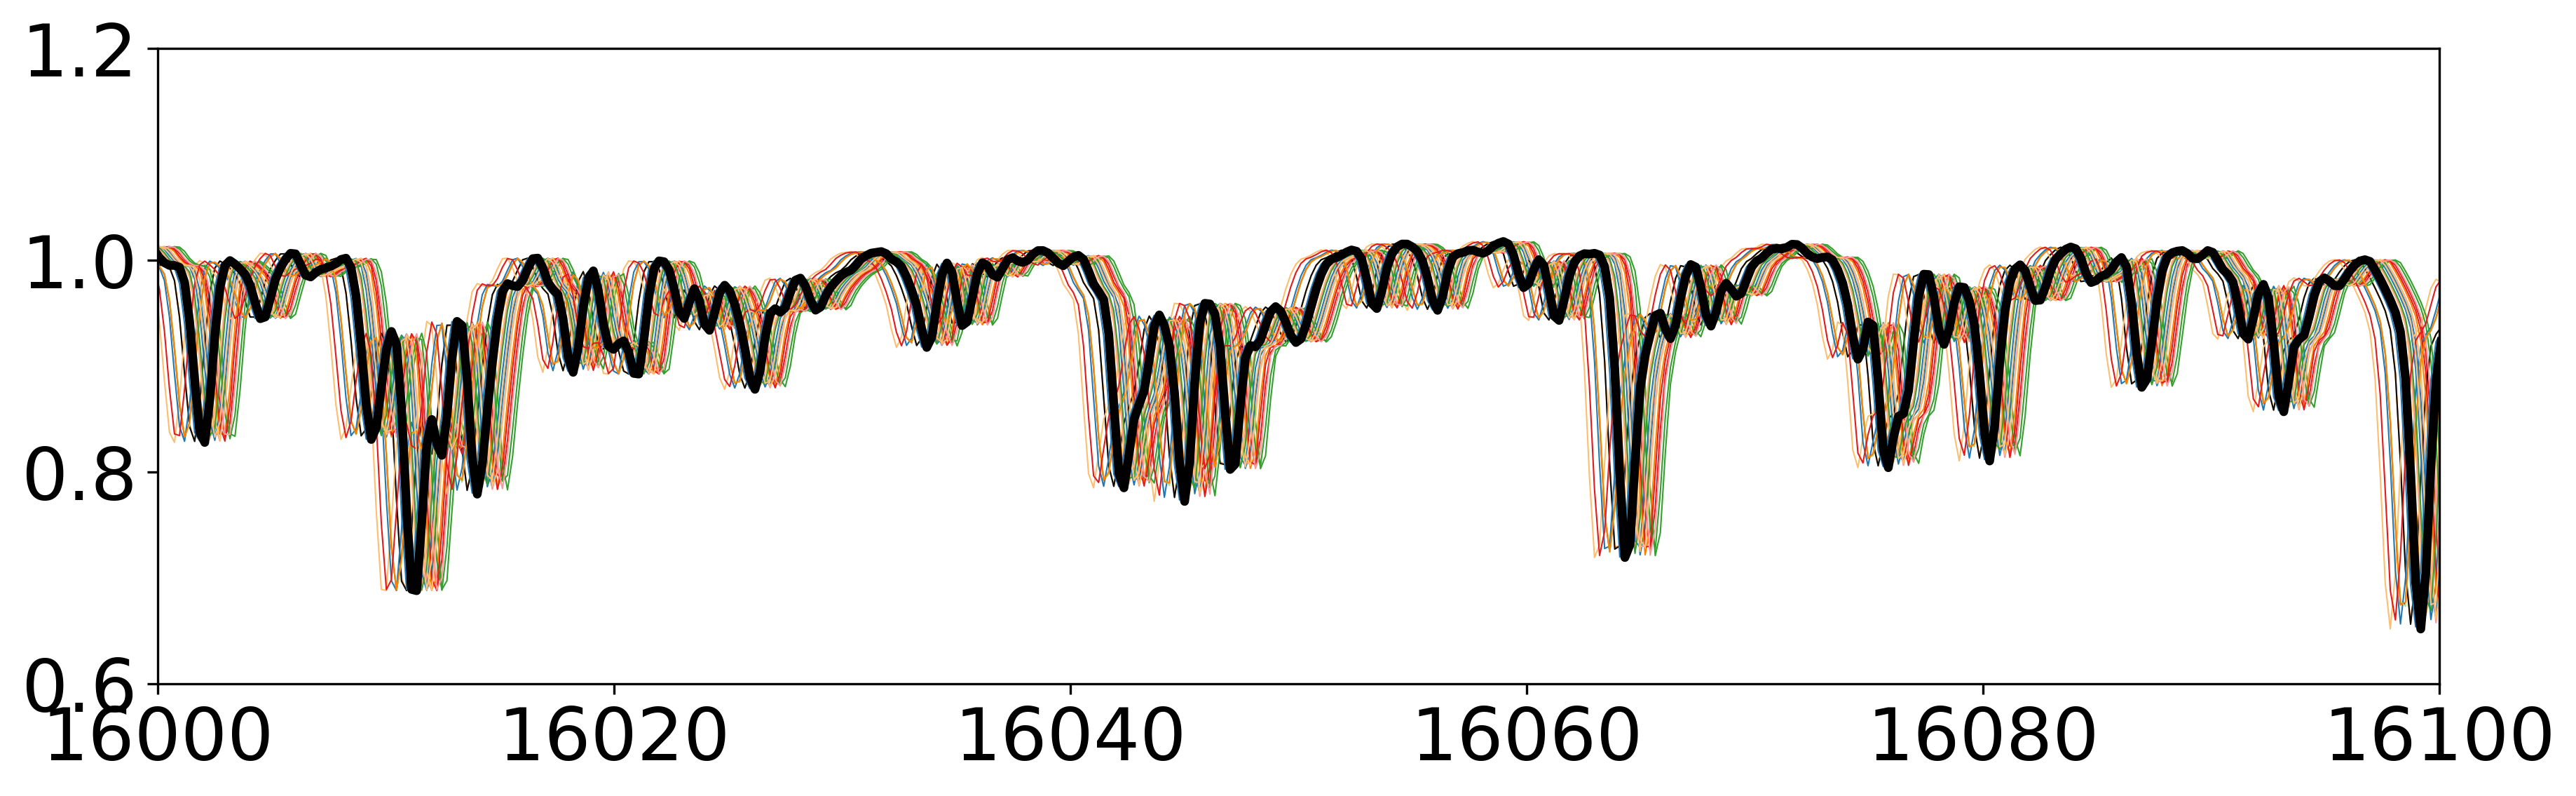

In [5]:
# consider a red clump stars
Teff1 = 4750.
logg1 = 2.5
feh = 0.
alphafe = 0.
vmacro = 2.

# make RV curve
num_obs = 30
RV_array = np.random.uniform(size=num_obs)*50. -25.

# just for normalization, we assume noiseless first
spec_err = 1e-2*np.ones(len(wavelength))
  
#--------------------------------------------------------------------------------------------------
# extract flux spectra
spec_array = []

# make n_obs of mock observations
for i in range(RV_array.size):
    #labels1 = [Teff1, logg1, feh, alphafe, vmacro, RV_array[i]] ## RV shift
    labels1 = [Teff1, logg1, feh, alphafe, vmacro, 0] ## no RV shift
    spec_array.append(get_normalized_spectrum_single_star(labels = labels1, 
            NN_coeffs_norm = NN_coeffs_norm, NN_coeffs_flux = NN_coeffs_flux))
    
spec_array = np.array(spec_array)
print(spec_array.shape)

#--------------------------------------------------------------------------------------------------
# code up interp1d ourselves -- will come in handy to translate this to pytrorch, since 
# pytroch deos not have interp1d
c = 3e5
spec_shifted = []
for i in range(RV_array.size):
    doppler_factor = np.sqrt((1 - RV_array[i]/c)/(1 + RV_array[i]/c))  
    new_wavelength = wavelength*doppler_factor
    ind = np.searchsorted(wavelength[:-1], new_wavelength) - 1
    slopes = (spec_array[i,1:] - spec_array[i,:-1])/(wavelength[1:]-wavelength[:-1])
    spec_shifted.append(spec_array[i,ind] + slopes[ind]*(new_wavelength - wavelength[ind])) 
spec_shifted = np.array(spec_shifted)


#==================================================================================================
# plot the spectrum
lambda_min, lambda_max = 16000, 16100# for plotting 
plt.figure(figsize=(14, 4))
plt.plot(wavelength, spec_shifted.T, lw=0.5)
plt.xlim(lambda_min, lambda_max)
plt.plot(wavelength, spec_array[0,:], color="black", lw=3) ## rest frame spectrum
plt.ylim(0.6, 1.2)


> Check that pytorch doppler shift prescription works.

(0.6, 1.2)

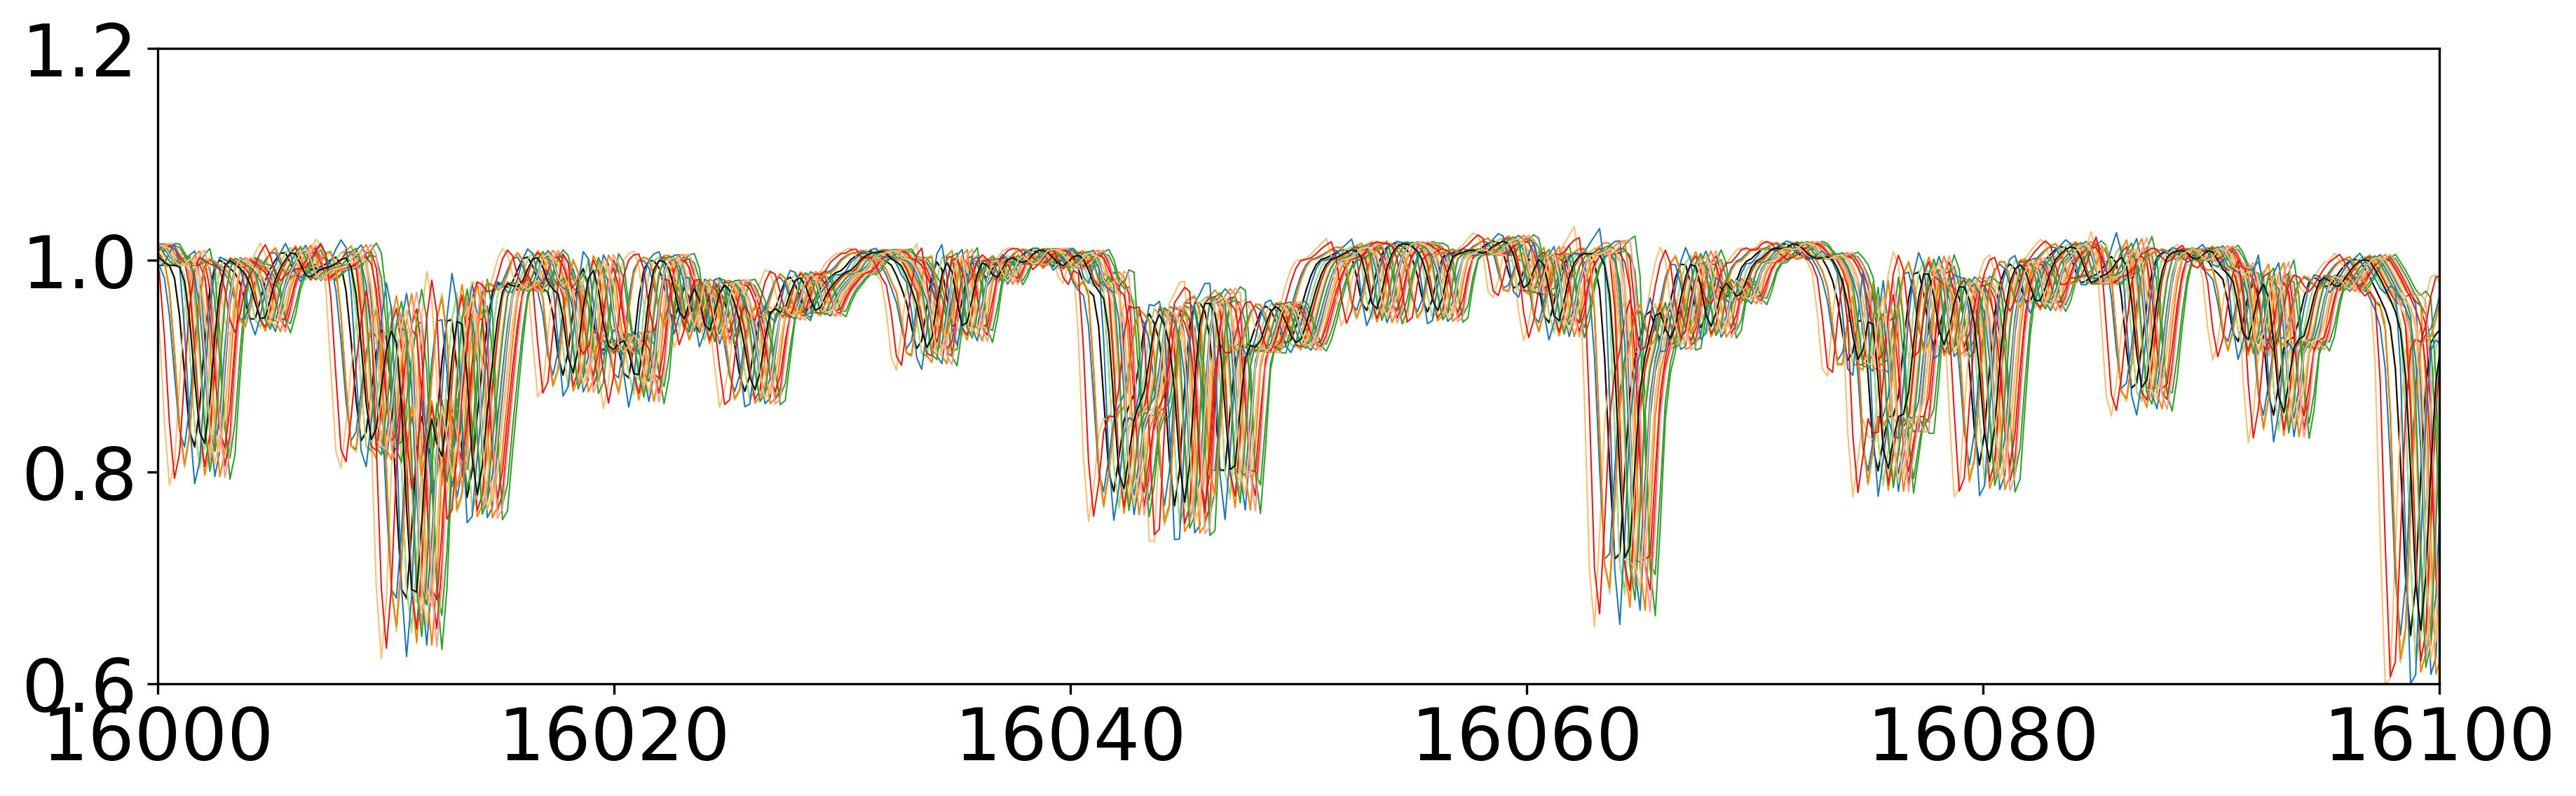

In [6]:
# import packages
import numpy as np
import sys
import os
import torch
from torch.autograd import Variable


#========================================================================================================
# write a searchsorted version for pytorch
def torch_searchsorted(x,y):
    
    # initiate result array
    search_sorted = torch.empty(y.shape[0], x.shape[0] + y.shape[1], dtype=torch.long)
    
    ### not an optimal implementation ### 
    ### should do better without using the two loops ###
        
    # loop over entries of y
    for i in range(y.shape[0]):
        cat_array = torch.cat((x,y[i,:]))
        ind_sort = torch.argsort(cat_array)
    
        # perform search sortted
        counter = 0
        val = 0
        
        while counter < ind_sort.shape[0]:
            if ind_sort[counter] > val:
                search_sorted[i,ind_sort[counter]] = val
            else:
                val += 1
            counter +=1
            
    return search_sorted[:,x.shape[0]:]
    
    
#========================================================================================================
### run on CPU ### 
# better run on GPU when you setup 
dtype = torch.FloatTensor
torch.set_default_tensor_type('torch.FloatTensor')
   
#---------------------------------------------------------------------------------------------------------
# make pytorch variables
spec = Variable(torch.from_numpy(spec_array[0,:])).type(dtype)
wave = Variable(torch.from_numpy(wavelength)).type(dtype)
c = 3e5 #km/s
RV_torch = Variable(torch.from_numpy(RV_array)).type(dtype)

# doppler shift
doppler_shift = torch.sqrt((1 - RV_torch/c)/(1 + RV_torch/c))
new_wavelength = torch.t(torch.ger(wave, doppler_shift)) # torch.ger = np.outer, outer product
ind = torch_searchsorted(wave[:-1], new_wavelength)
ind[ind == num_pixel - 1] = num_pixel - 2 ## fix a border index problem
slopes = (spec[1:] - spec[:-1])/(wave[1:]-wave[:-1])
spec_shifted_torch = spec[ind] + slopes[ind]*(new_wavelength - wave[ind])


#========================================================================================================
# plot the spectrum
lambda_min, lambda_max = 16000, 16100# for plotting 
plt.figure(figsize=(14, 4))
plt.plot(wavelength, spec_shifted_torch.data.numpy().T, lw=0.5)
plt.xlim(lambda_min, lambda_max)
plt.ylim(0.6, 1.2)


> To recover the RV curve, we want to optimize for a spectral template (a vector of n_pixel) - independent of the input as well as the RV (a mapping from spectrum to a number).


In [8]:
# import packages
import numpy as np
import sys
import os
import torch
from torch.autograd import Variable


#========================================================================================================
# number of pixesls
num_pixel = 7214

#----------------------------------------------------------------------------------------------------------
# make a rest frame model (tat does not depend on input)
class rest_spec(torch.nn.Module):
    def __init__(self):
        super(rest_spec, self).__init__()
        self.spec = torch.nn.Parameter(torch.rand(num_pixel)) ## initialize with an array of [0,1] uniform numbers
        
    def forward(self):
        y_pred = self.spec ## does not depend on input
        return y_pred

# initiate the model
rest_spec_model = rest_spec()

#----------------------------------------------------------------------------------------------------------
# number of neurons, probably can get away with a network with a small capacity
num_neurons = 10

# definte a two-layer fully connected NN which map spectra to a number 
RV_mapper = torch.nn.Sequential(                                                                                              
        torch.nn.Linear(num_pixel, 10),
        torch.nn.Sigmoid(), # using sigmoid activation, but can use anything                                                                                                  
        torch.nn.Linear(10, 10),
        torch.nn.Sigmoid(),
        torch.nn.Linear(10, 1),
)


#========================================================================================================
# now optimize
### run on GPU ###
#dtype = torch.cuda.FloatTensor
#torch.set_default_tensor_type('torch.cuda.FloatTensor')

### run on CPU ### 
# better run on GPU when you setup 
dtype = torch.FloatTensor
torch.set_default_tensor_type('torch.FloatTensor')
   
#---------------------------------------------------------------------------------------------------------
# assume L2 loss
loss_fn = torch.nn.MSELoss()
    
# make pytorch variables
wave = Variable(torch.from_numpy(wavelength)).type(dtype)

# light speed for doppler shift 
c = 3e5 #km/s

# optimizer
learning_rate = 0.001
optimizer = torch.optim.Adam([{'params': rest_spec_model.parameters(), "lr": learning_rate},\
                              {'params': RV_mapper.parameters(), "lr": learning_rate}])

#---------------------------------------------------------------------------------------------------------
# initiate training
loss_data = 10**8
training_loss = []

# optimize
for i in range(10**2):
    if i % 10**1 == 0:
        print('Step ' + str(i) \
                + ': Training set loss = ' + str(int(loss_data*1e5)/1e5))
        
    # map spectra to RV
    RV_pred = RV_mapper(spec_shifted_torch).view(-1) # view(-1) to flatten the array

    # doppler shift # we do not train this - this is physical
    spec = rest_spec_model.spec
    doppler_shift = torch.sqrt((1 - RV_pred/c)/(1 + RV_pred/c))
    new_wavelength = torch.t(torch.ger(wave, doppler_shift)) # torch.ger = np.outer, outer product
    ind = torch_searchsorted(wave[:-1], new_wavelength) ### numpy break the graph ### 
    ind[ind == num_pixel - 1] = num_pixel - 2 # fix a border index problem
    slopes = (spec[1:] - spec[:-1])/(wave[1:]-wave[:-1])
    spec_shifted_recovered = spec[ind] + slopes[ind]*(new_wavelength - wave[ind])

    # the loss function is simply comparing the reconstructed spectra vs. spectrum
    loss = loss_fn(spec_shifted_recovered, spec_shifted_torch)

#---------------------------------------------------------------------------------------------------------
    # back propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # record training loss
    loss_data = loss.data.item()
    training_loss.append(loss_data)


Step 0: Training set loss = 100000000.0
Step 10: Training set loss = 0.32132
Step 20: Training set loss = 0.30781
Step 30: Training set loss = 0.29677


KeyboardInterrupt: 

In [ ]:
# let check how well we recover the rest frame spectrum
# plot the spectrum
lambda_min, lambda_max = 16000, 16100# for plotting 
plt.figure(figsize=(14, 4))
plt.plot(wavelength, spec_array[0,:], lw=0.5)
plt.xlim(lambda_min, lambda_max)
plt.plot(wavelength,rest_spec_model.spec.data.numpy(), color="black", lw=2)
plt.ylim(0.6, 1.2)
